# Dependencies

In [383]:
import pandas as pd
import pdb
import seaborn as sns
import numpy as np

%matplotlib inline

# Input data

In [384]:
DF=pd.read_csv('/Users/ernesto/Downloads/Screenshot analysis - train_counter_doubletop.tsv',sep='\t',na_values="n.a.")
    
DF.shape

(115, 29)

And some information about DF:

In [385]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 29 columns):
timeframe                           115 non-null object
id 1st peak                         115 non-null object
start 1st peak                      115 non-null object
entry 1st peak                      115 non-null float64
S/L 1st peak                        33 non-null float64
outcome 1st peak                    115 non-null object
retraced 1st peak                   26 non-null float64
last time 1st peak                  114 non-null object
Candle +1 against trade 1st peak    115 non-null bool
RSI bounces 1st peak                115 non-null int64
RSI 1st peak                        115 non-null int64
No of candles 1st peak              109 non-null float64
bounce length 1st peak              109 non-null object
indecission 1st peak                115 non-null int64
divergence 1st peak                 115 non-null bool
entry on RSI 1st peak               115 non-null bool
length

* Conversion to right types<br>
Let's convert now the `last time 1st peak` variables to DateTime

In [386]:
DF['start 1st peak']= pd.to_datetime(DF['start 1st peak'])
DF['last time 1st peak']= pd.to_datetime(DF['last time 1st peak'])

## Transforming

In [387]:
transl_dict={ 
        'S':1,
        'F':0, 
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''
    
    return transl_dict[x[name]]

DF['outcome 1st peak']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='outcome 1st peak')
DF['Candle +1 against trade 1st peak']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='Candle +1 against trade 1st peak')
DF['divergence 1st peak']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='divergence 1st peak')
DF['entry on RSI 1st peak']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='entry on RSI 1st peak')
DF['divergence 2nd peak']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='divergence 2nd peak')
DF['outcome 2nd peak']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='outcome 2nd peak')

## Cleaning the n.a. values

In [388]:
DF["No of candles 1st peak"].fillna(0, inplace=True)
DF["bounce length 1st peak"].fillna(0, inplace=True)

## Proportion of outcome for first and second peak

* First peak

In [389]:
outcome1st_ix=5
DF.iloc[:,outcome1st_ix].value_counts()

1    80
0    35
Name: outcome 1st peak, dtype: int64

* Second peak

In [390]:
outcome2nd_ix=23
DF.iloc[:,outcome2nd_ix].value_counts()

1    82
0    33
Name: outcome 2nd peak, dtype: int64

### last time 1st peak
This datetime variable represents the last time the price was over/below the entry price level. The first to do is to create a new datetime variable representing the difference (in days) between the entry datetime (start column) and the last time datetime.

In [391]:
DF['diff']=(DF['start 1st peak']-DF['last time 1st peak'])

In [392]:
DF['diff']=DF['diff'].apply(lambda x: x.days)

Now, let's examine the distribution of this newly created `diff` variable in the 2 `outcome` categories

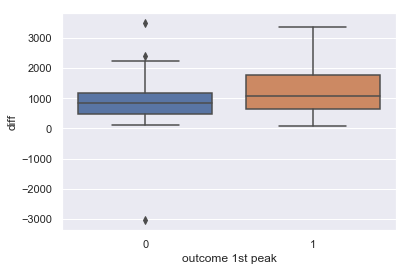

In [393]:
ax = sns.boxplot(x="outcome 1st peak", y="diff", data=DF)

* Mean for each category

In [394]:
DF.groupby("outcome 1st peak").agg({'diff': 'mean'})

,diff
outcome 1st peak,
0,905.200000
1,1310.012658


In [395]:
DF.groupby("outcome 2nd peak").agg({'diff': 'mean'})

,diff
outcome 2nd peak,
0,1233.636364
1,1166.209877


* Median for each category

In [396]:
DF.groupby("outcome 1st peak").agg({'diff': 'median'})

,diff
outcome 1st peak,
0,830.0
1,1062.0


In [397]:
DF.groupby("outcome 2nd peak").agg({'diff': 'median'})

,diff
outcome 2nd peak,
0,950.0
1,1005.0


#### Binning data

Let's bin the data into a certain number of categories

In [398]:
max_v=max(DF['diff'])

custom_bins_array = np.arange(0, max_v, 500)

DF['diff_cat']=pd.cut(DF['diff'], np.around(custom_bins_array))

##### outcome 1st peak

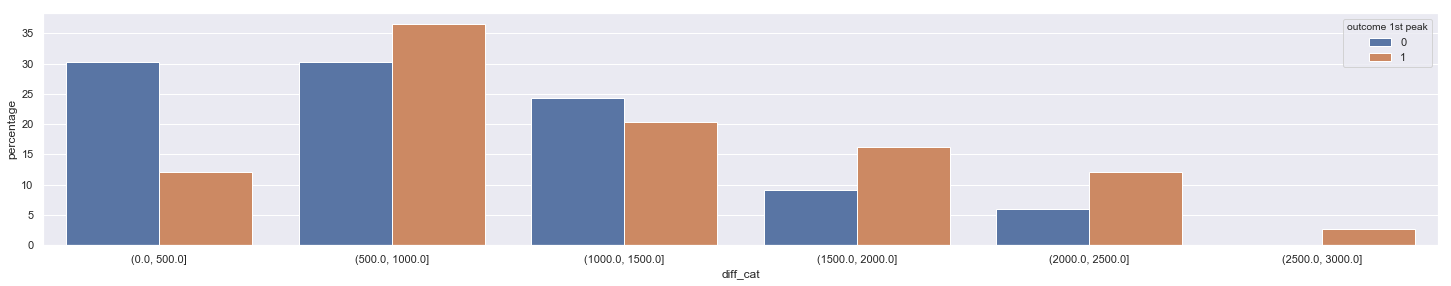

In [399]:
DF_counts = (DF.groupby(['outcome 1st peak'])['diff_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('diff_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="diff_cat", y="percentage", hue='outcome 1st peak', data=DF_counts)

##### outcome 2nd peak

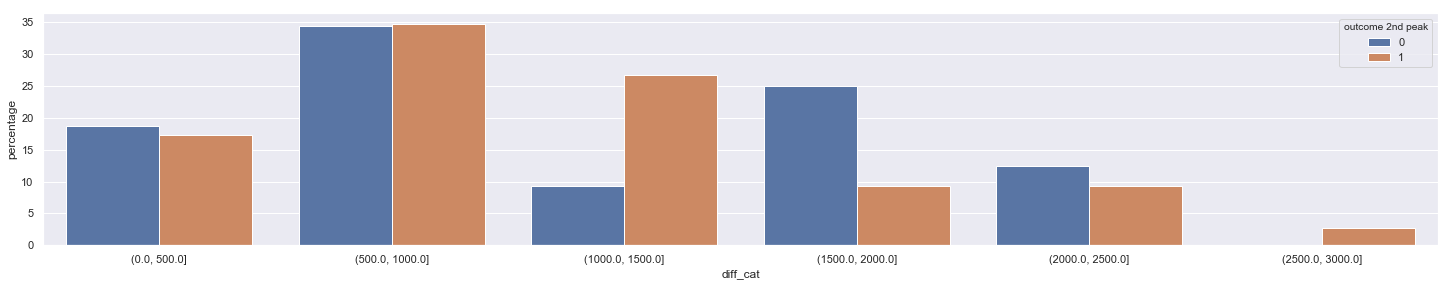

In [400]:
DF_counts = (DF.groupby(['outcome 2nd peak'])['diff_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('diff_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="diff_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

### RSI bounces 1st peak 
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

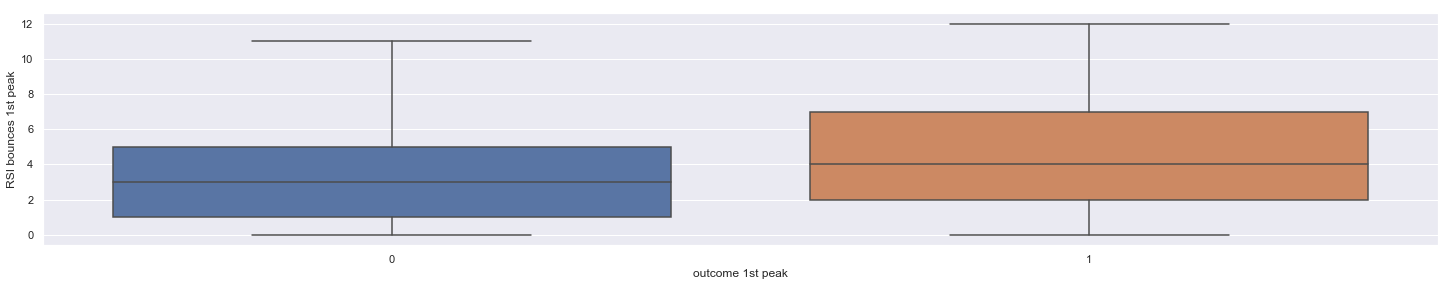

In [401]:
ax = sns.boxplot(x="outcome 1st peak", y="RSI bounces 1st peak", data=DF)

* Mean for each category

In [402]:
DF.groupby("outcome 1st peak").agg({'RSI bounces 1st peak': 'mean'})

,RSI bounces 1st peak
outcome 1st peak,
0,3.514286
1,4.300000


In [403]:
DF.groupby("outcome 2nd peak").agg({'RSI bounces 1st peak': 'mean'})

,RSI bounces 1st peak
outcome 2nd peak,
0,3.515152
1,4.280488


* Median for each category

In [404]:
medianBounce=DF.groupby("outcome 1st peak").agg({'RSI bounces 1st peak': 'median'})
print(medianBounce)

                  RSI bounces 1st peak
outcome 1st peak                      
0                                    3
1                                    4


In [405]:
medianBounce=DF.groupby("outcome 2nd peak").agg({'RSI bounces 1st peak': 'median'})
print(medianBounce)

                  RSI bounces 1st peak
outcome 2nd peak                      
0                                    3
1                                    4


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

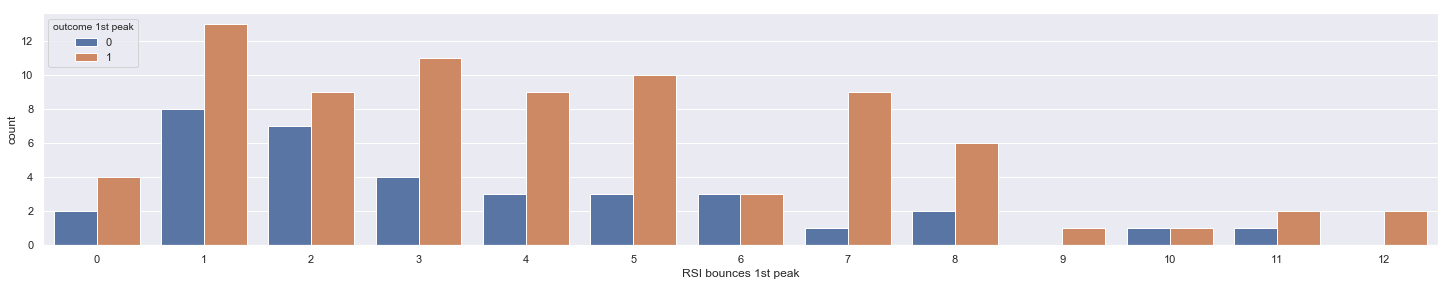

In [406]:
ax = sns.countplot(x="RSI bounces 1st peak",hue="outcome 1st peak", data=DF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

##### outcome 1st peak

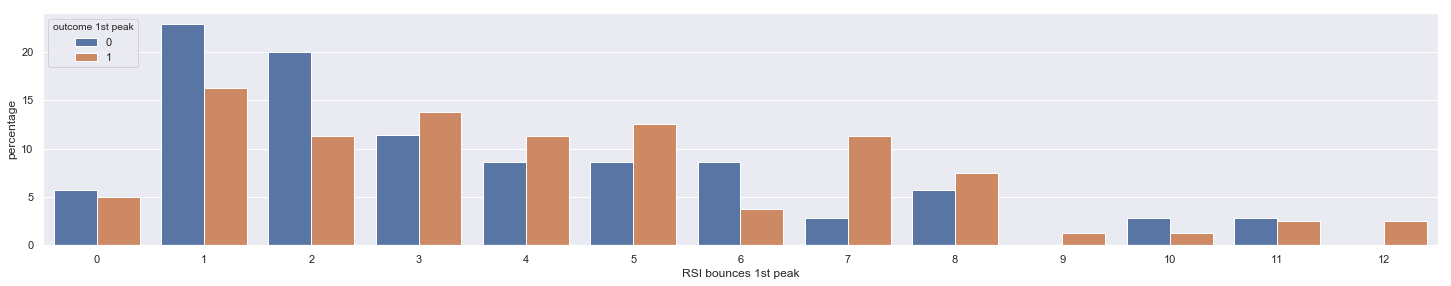

In [407]:
DF_counts = (DF.groupby(["outcome 1st peak"])['RSI bounces 1st peak']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('RSI bounces 1st peak'))

p = sns.barplot(x="RSI bounces 1st peak", y="percentage", hue="outcome 1st peak", data=DF_counts)

##### outcome 2nd peak

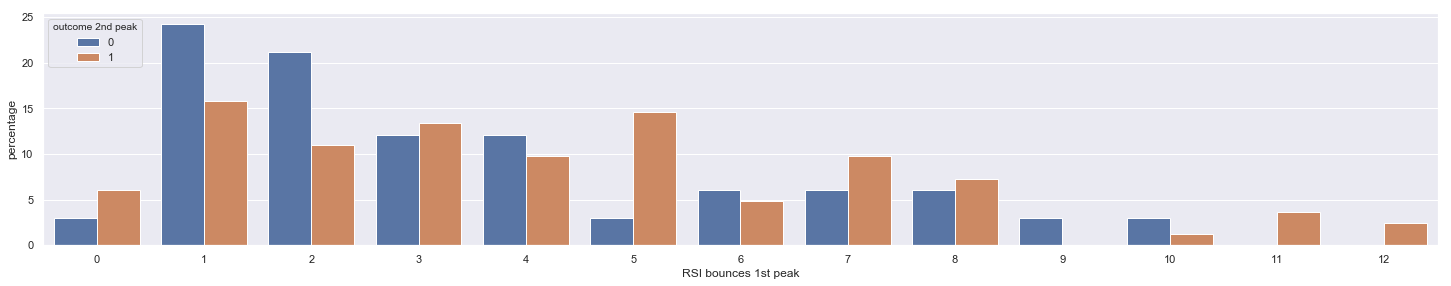

In [408]:
DF_counts = (DF.groupby(["outcome 2nd peak"])['RSI bounces 1st peak']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('RSI bounces 1st peak'))

p = sns.barplot(x="RSI bounces 1st peak", y="percentage", hue="outcome 2nd peak", data=DF_counts)

* Histogram

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for RSI bounces on the outcome')

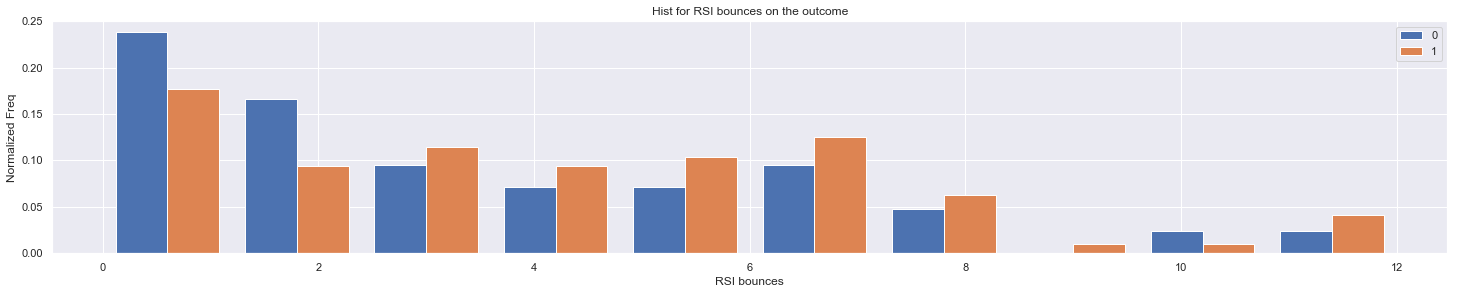

In [409]:
import matplotlib.pyplot as plt

succ=DF.loc[DF["outcome 1st peak"]==1]['RSI bounces 1st peak']
fail=DF.loc[DF["outcome 1st peak"]==0]['RSI bounces 1st peak']

plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('RSI bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for RSI bounces on the outcome')

### RSI 1st peak 
This numerical variable represents the value of the RSI indicator for the 1st peak. We will create a categorical variable that will be 1 if the value is in overbought/oversold region (>70 or <30 respectively) and 0 otherwise. For that calculation we define the following function:

In [410]:
def in_RSIarea(x):
    '''
    Function to check if the RSI indicator value is in overbought/oversold region
    
    Parameters
    ----------
    x = number representing the RSI value
        
    Returns
    -------
    1 if value is in overbought/oversold
    0 otherwise
    '''
   
    if x>=70 or x<=30: 
        return 1
    else:
        return 0

In [411]:
DF['rsi_inarea_1st']=DF['RSI 1st peak'].apply(in_RSIarea)

Let's check if `outcome 1st peak` is conditioned by `rsi_inarea_1st`:

In [412]:
div_class=pd.crosstab(DF.loc[:,"outcome 1st peak"], DF['rsi_inarea_1st'],margins=True)
print(div_class)

rsi_inarea_1st     0    1  All
outcome 1st peak              
0                  3   32   35
1                 10   70   80
All               13  102  115


In [413]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

rsi_inarea_1st             0           1         All
outcome 1st peak                                    
0                  23.076923   31.372549   30.434783
1                  76.923077   68.627451   69.565217
All               100.000000  100.000000  100.000000


Now, let's calculate the percentages of trades in oversold/overbought depending on the `outcome 2nd peak` variable:

In [414]:
div_class=pd.crosstab(DF.loc[:,"outcome 2nd peak"], DF['rsi_inarea_1st'],margins=True)
print(div_class)

rsi_inarea_1st     0    1  All
outcome 2nd peak              
0                  8   25   33
1                  5   77   82
All               13  102  115


In [415]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

rsi_inarea_1st             0           1         All
outcome 2nd peak                                    
0                  61.538462   24.509804   28.695652
1                  38.461538   75.490196   71.304348
All               100.000000  100.000000  100.000000


*Conclusion:* The RSI value being in overbought/oversold is a good predictor for the `outcome 2nd peak` variable and it is irrelevant for predicting the `outcome 1st peak`

### No of candles 1st peak 
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome 1st peak` variable. As an initial exploration I will create a boxplot displaying the data:

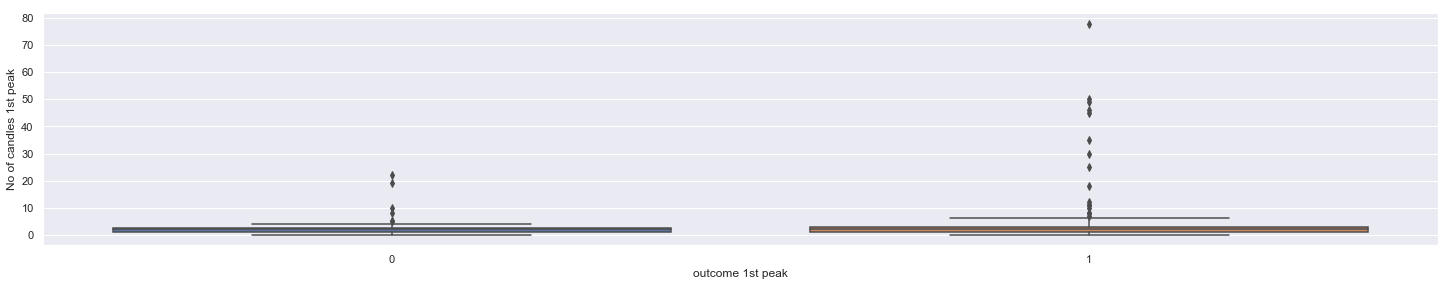

In [416]:
ax = sns.boxplot(x="outcome 1st peak", y="No of candles 1st peak", data=DF)

* Mean for each category

In [417]:
DF.groupby("outcome 1st peak").agg({'No of candles 1st peak': 'mean'})

,No of candles 1st peak
outcome 1st peak,
0,3.257143
1,6.750000


In [418]:
DF.groupby("outcome 2nd peak").agg({'No of candles 1st peak': 'mean'})

,No of candles 1st peak
outcome 2nd peak,
0,7.909091
1,4.792683


* Median for each category

In [419]:
DF.groupby("outcome 1st peak").agg({'No of candles 1st peak': 'median'})

,No of candles 1st peak
outcome 1st peak,
0,2.0
1,2.0


In [420]:
DF.groupby("outcome 2nd peak").agg({'No of candles 1st peak': 'median'})

,No of candles 1st peak
outcome 2nd peak,
0,1.0
1,2.0


* Histogram

In [421]:
succ=DF.loc[DF["outcome 1st peak"]==1]['No of candles 1st peak']
fail=DF.loc[DF["outcome 1st peak"]==0]['No of candles 1st peak']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for No of candles depending on the outcome')

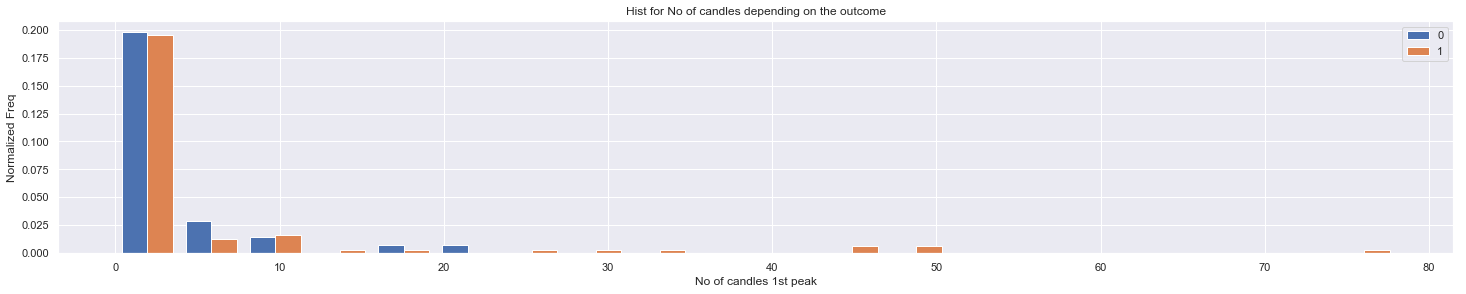

In [422]:
plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('No of candles 1st peak')
plt.ylabel('Normalized Freq')
plt.title('Hist for No of candles depending on the outcome')

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for No of candles 1st peak depending on the outcome')

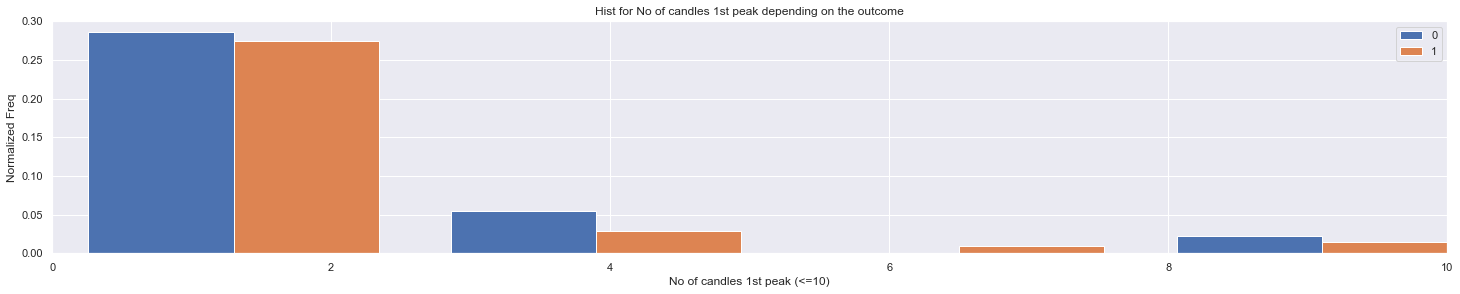

In [423]:
plt.xlim(0,10)
plt.hist([fail,succ], bins = 30, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('No of candles 1st peak (<=10)')
plt.ylabel('Normalized Freq')
plt.title('Hist for No of candles 1st peak depending on the outcome')

#### Binning data
Let's bin the data into a certain number of categories

In [424]:
max_v=max(DF['No of candles 1st peak'])

custom_bins_array = np.arange(0, max_v, 2)

DF['No of candles 1st peak_cat']=pd.cut(DF['No of candles 1st peak'], np.around(custom_bins_array))

##### outcome 1st peak

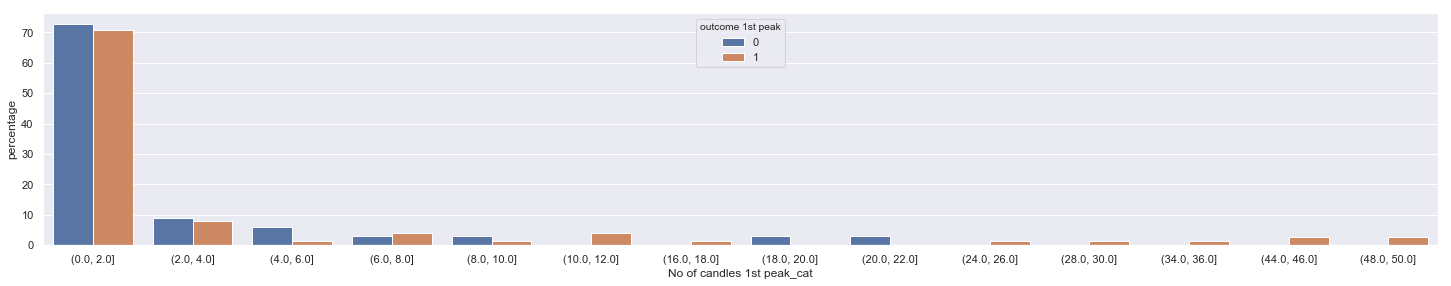

In [425]:
contDF_counts = (DF.groupby(['outcome 1st peak'])['No of candles 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('No of candles 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="No of candles 1st peak_cat", y="percentage", hue='outcome 1st peak', data=contDF_counts)

##### outcome 2nd peak

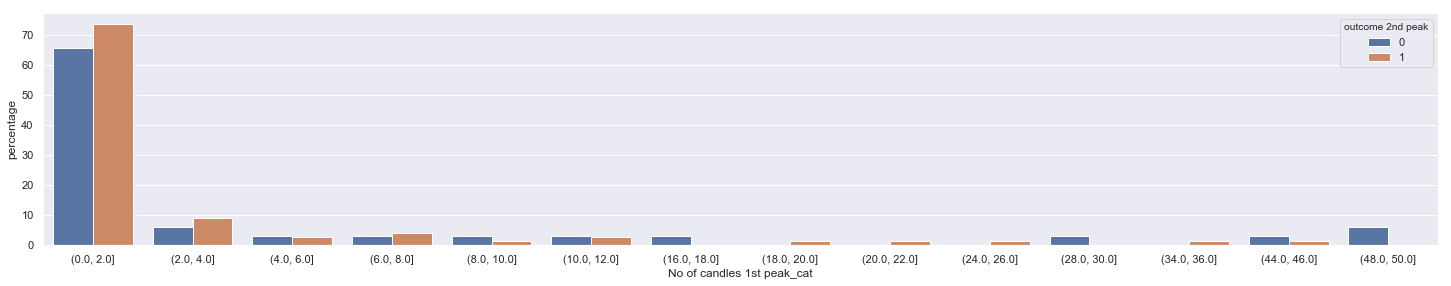

In [426]:
contDF_counts = (DF.groupby(['outcome 2nd peak'])['No of candles 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('No of candles 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="No of candles 1st peak_cat", y="percentage", hue='outcome 2nd peak', data=contDF_counts)

### bounce length 1st peak
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [427]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    
    return sum([int(i) for i in x.split(",")])

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [428]:
DF['sum_bounces']=DF['bounce length 1st peak'].astype(str).apply(sum_lengths)

Now, I will plot the distribution of this new variable on each `outcome`category:

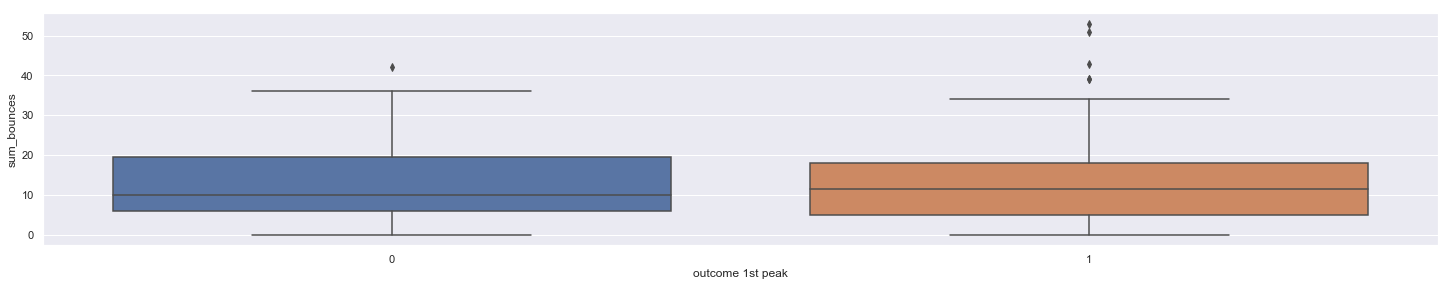

In [429]:
ax = sns.boxplot(x="outcome 1st peak", y="sum_bounces", data=DF)

* Mean for each category

In [430]:
DF.groupby("outcome 1st peak").agg({'sum_bounces': 'mean'})

,sum_bounces
outcome 1st peak,
0,13.485714
1,13.562500


In [431]:
DF.groupby("outcome 2nd peak").agg({'sum_bounces': 'mean'})

,sum_bounces
outcome 2nd peak,
0,11.636364
1,14.304878


* Median for each category

In [432]:
DF.groupby("outcome 1st peak").agg({'sum_bounces': 'median'})

,sum_bounces
outcome 1st peak,
0,10.0
1,11.5


In [433]:
DF.groupby("outcome 2nd peak").agg({'sum_bounces': 'median'})

,sum_bounces
outcome 2nd peak,
0,8
1,12


* Histogram

In [434]:
succ=DF.loc[DF["outcome 1st peak"]==1]['sum_bounces']
fail=DF.loc[DF["outcome 1st peak"]==0]['sum_bounces']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for sum_bounces depending on the outcome')

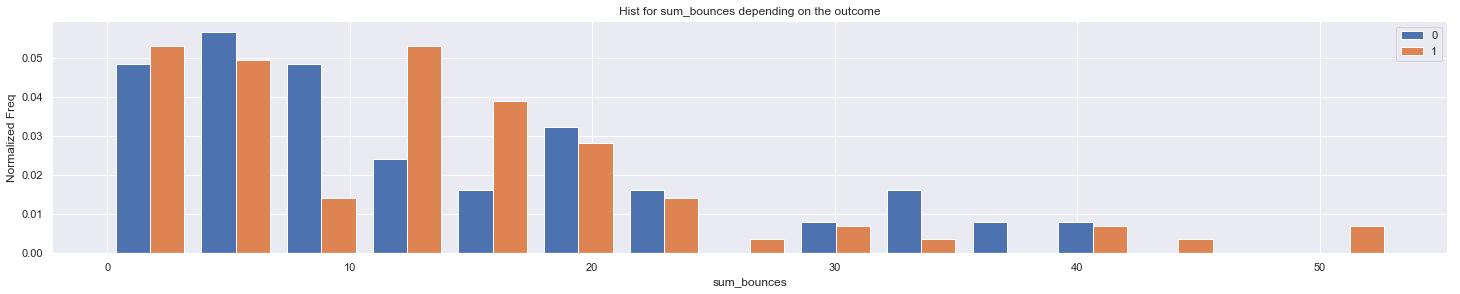

In [435]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('sum_bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for sum_bounces depending on the outcome')

#### Binning data
Let's bin the data into a certain number of categories

In [436]:
max_v=max(DF['sum_bounces'])

custom_bins_array = np.arange(0, max_v, 5)

DF['sum_bounces_cat']=pd.cut(DF['sum_bounces'], np.around(custom_bins_array))

##### outcome 1st peak

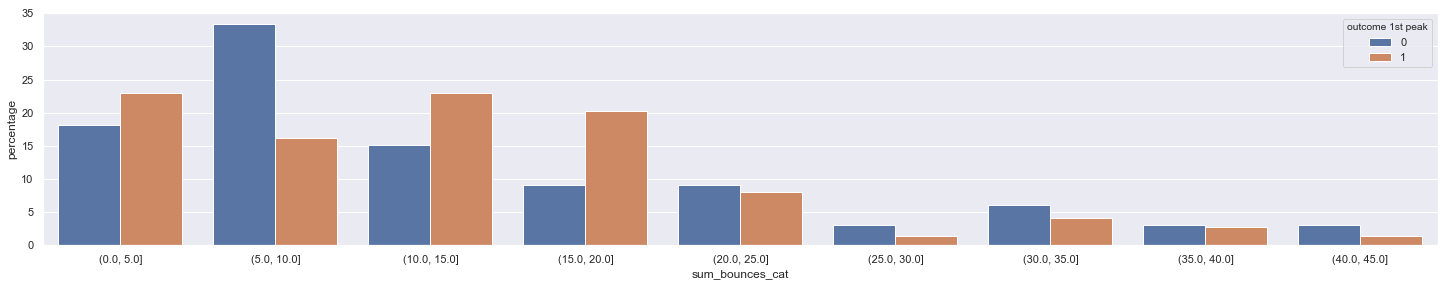

In [437]:
DF_counts = (DF.groupby(['outcome 1st peak'])['sum_bounces_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('sum_bounces_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="sum_bounces_cat", y="percentage", hue='outcome 1st peak', data=DF_counts)

##### outcome 2nd peak

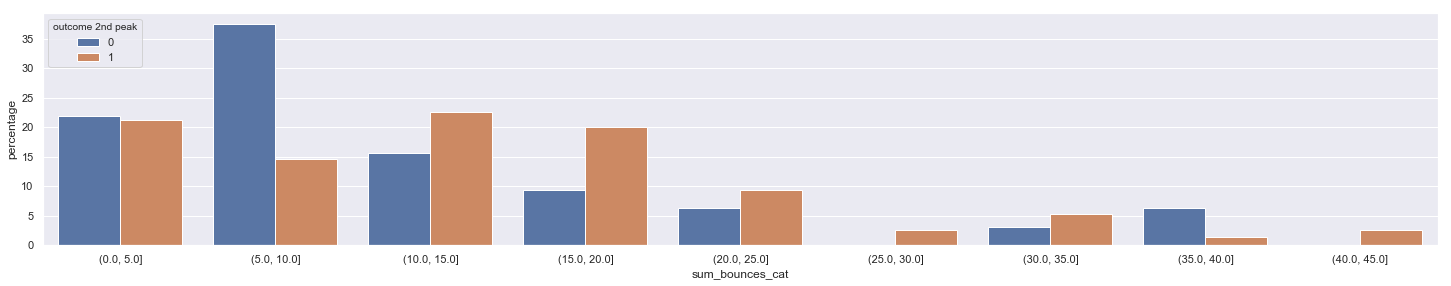

In [438]:
DF_counts = (DF.groupby(['outcome 2nd peak'])['sum_bounces_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('sum_bounces_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="sum_bounces_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

###  indecission 1st peak
Number of candles the price stays in S/R

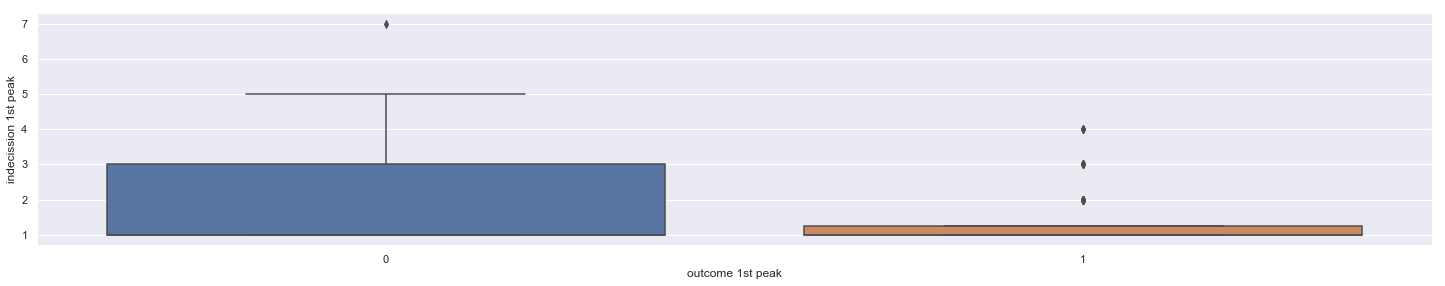

In [439]:
ax = sns.boxplot(x="outcome 1st peak", y="indecission 1st peak", data=DF)

* Mean for each category

In [440]:
DF.groupby("outcome 1st peak").agg({'indecission 1st peak': 'mean'})

,indecission 1st peak
outcome 1st peak,
0,2.057143
1,1.387500


In [441]:
DF.groupby("outcome 2nd peak").agg({'indecission 1st peak': 'mean'})

,indecission 1st peak
outcome 2nd peak,
0,1.393939
1,1.670732


* Median for each category

In [442]:
medianBounce=DF.groupby('outcome 1st peak').agg({'indecission 1st peak': 'median'})
print(medianBounce)

                  indecission 1st peak
outcome 1st peak                      
0                                    1
1                                    1


In [443]:
medianBounce=DF.groupby('outcome 2nd peak').agg({'indecission 1st peak': 'median'})
print(medianBounce)

                  indecission 1st peak
outcome 2nd peak                      
0                                    1
1                                    1


#### Binning data
Let's bin the data into a certain number of categories

In [444]:
max_v=max(DF['indecission 1st peak'])

custom_bins_array = np.arange(0, max_v, 1)

DF['indecission 1st peak_cat']=pd.cut(DF['indecission 1st peak'], np.around(custom_bins_array))

##### outcome 1st peak

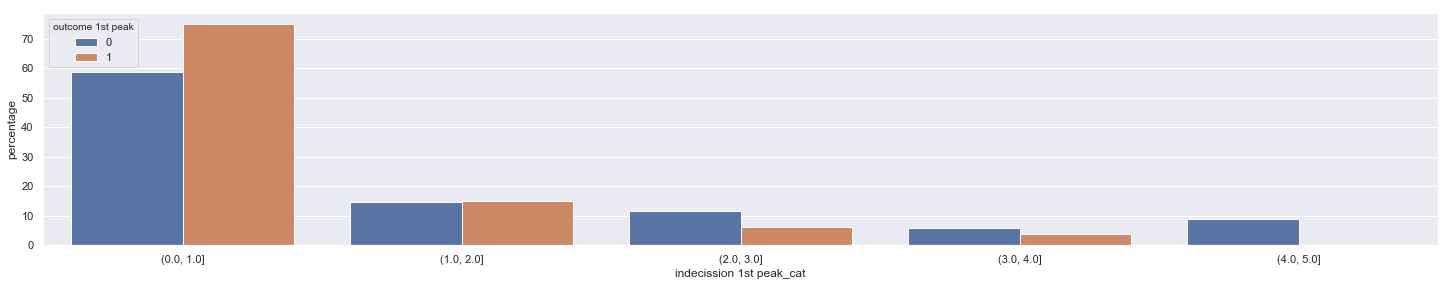

In [445]:
DF_counts = (DF.groupby(['outcome 1st peak'])['indecission 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('indecission 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="indecission 1st peak_cat", y="percentage", hue='outcome 1st peak', data=DF_counts)

##### outcome 2nd peak

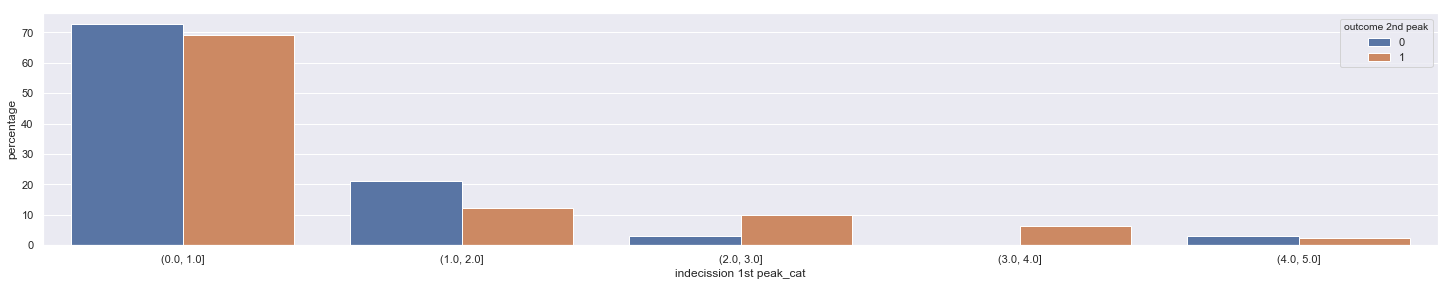

In [446]:
DF_counts = (DF.groupby(['outcome 2nd peak'])['indecission 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('indecission 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="indecission 1st peak_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

### divergence 1st peak

Let's compare the proportions for this variable between the 2 categories of the `outcome 1st peak` variable

In [447]:
div_class=pd.crosstab(DF.loc[:,"outcome 1st peak"], DF['divergence 1st peak'],margins=True)
print(div_class)

divergence 1st peak   0   1  All
outcome 1st peak                
0                    18  17   35
1                    44  36   80
All                  62  53  115


It's is easier to visualize the relationship if we calculate the percentages:

In [448]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

divergence 1st peak           0           1         All
outcome 1st peak                                       
0                     29.032258   32.075472   30.434783
1                     70.967742   67.924528   69.565217
All                  100.000000  100.000000  100.000000


Now, let's check if `divergence 1st peak` is a good predictor of the `outcome 2nd peak`:

In [449]:
div_class=pd.crosstab(DF.loc[:,"outcome 2nd peak"], DF['divergence 1st peak'],margins=True)
print(div_class)

divergence 1st peak   0   1  All
outcome 2nd peak                
0                    20  13   33
1                    42  40   82
All                  62  53  115


And calculating the percentages:

In [450]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

divergence 1st peak           0           1         All
outcome 2nd peak                                       
0                     32.258065   24.528302   28.695652
1                     67.741935   75.471698   71.304348
All                  100.000000  100.000000  100.000000


### entry on RSI 1st peak

This boolean variable will be True if the entry of the trade is in oversold/overbought RSI
First, let's see the counts for each category of the variable:

In [451]:
DF['entry on RSI 1st peak'].value_counts()

0    105
1     10
Name: entry on RSI 1st peak, dtype: int64

Let's compare the proportions for this variable between the 2 categories of the `outcome 1st peak` variable

In [452]:
div_class=pd.crosstab(DF.loc[:,'outcome 1st peak'], DF['entry on RSI 1st peak'],margins=True)
print(div_class)

entry on RSI 1st peak    0   1  All
outcome 1st peak                   
0                       31   4   35
1                       74   6   80
All                    105  10  115


It's is easier to visualize the relationship if we calculate the percentages:

In [453]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

entry on RSI 1st peak          0      1         All
outcome 1st peak                                   
0                       29.52381   40.0   30.434783
1                       70.47619   60.0   69.565217
All                    100.00000  100.0  100.000000


### length of trend 1st peak
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome 1st peak` and `outcome 2nd peak` variables:

#### outcome 1st peak

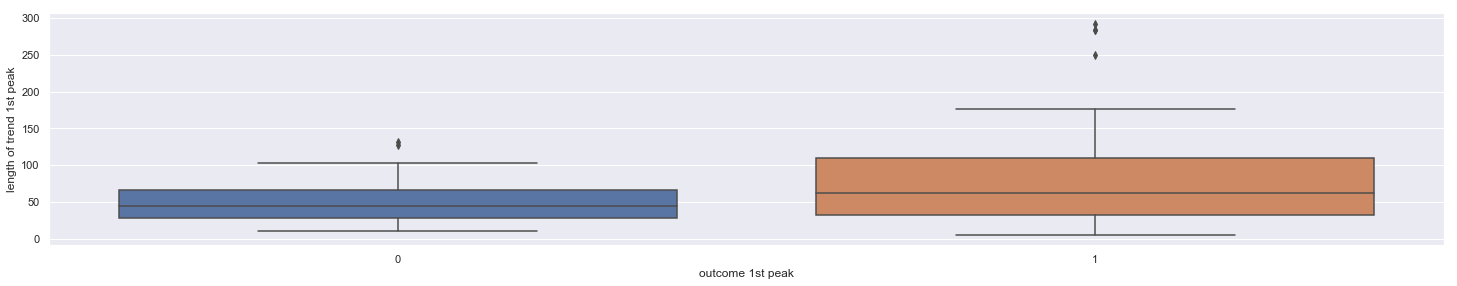

In [454]:
ax = sns.boxplot(x="outcome 1st peak", y="length of trend 1st peak", data=DF)

Let's analyze the distribution with a histogram

In [455]:
succ=DF.loc[DF["outcome 1st peak"]==1]['length of trend 1st peak']
fail=DF.loc[DF["outcome 1st peak"]==0]['length of trend 1st peak']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for Length of the trend depending on the outcome for 1st peak')

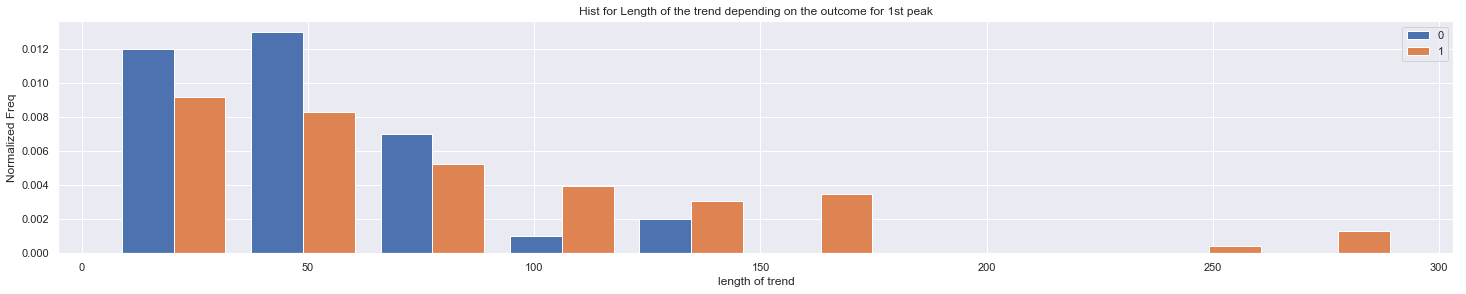

In [456]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of trend')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome for 1st peak')

* Mean for each category

In [457]:
DF.groupby("outcome 1st peak").agg({'length of trend 1st peak': 'mean'})

,length of trend 1st peak
outcome 1st peak,
0,50.857143
1,82.662500


* Median for each category

In [458]:
DF.groupby("outcome 1st peak").agg({'length of trend 1st peak': 'median'})

,length of trend 1st peak
outcome 1st peak,
0,45
1,63


#### outcome 2nd peak

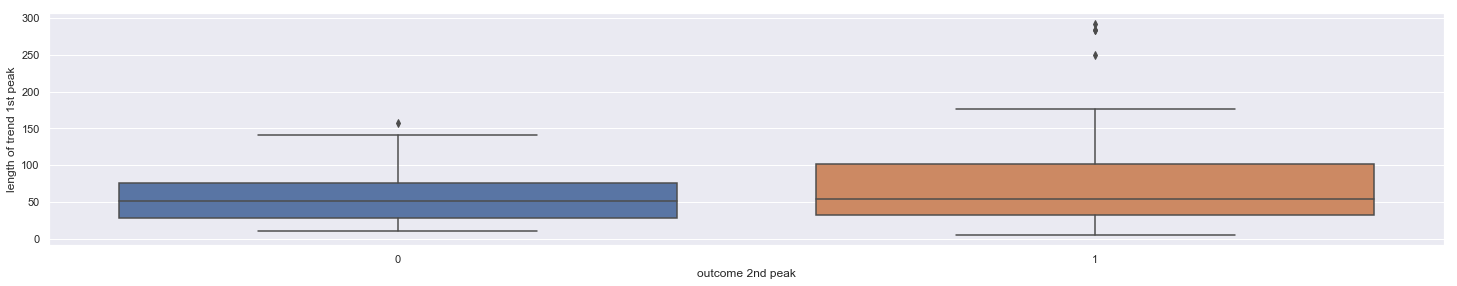

In [459]:
ax = sns.boxplot(x="outcome 2nd peak", y="length of trend 1st peak", data=DF)

Let's analyze the distribution with a histogram

In [460]:
succ=DF.loc[DF["outcome 2nd peak"]==1]['length of trend 1st peak']
fail=DF.loc[DF["outcome 2nd peak"]==0]['length of trend 1st peak']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for Length of the trend depending on the outcome for 2nd peak')

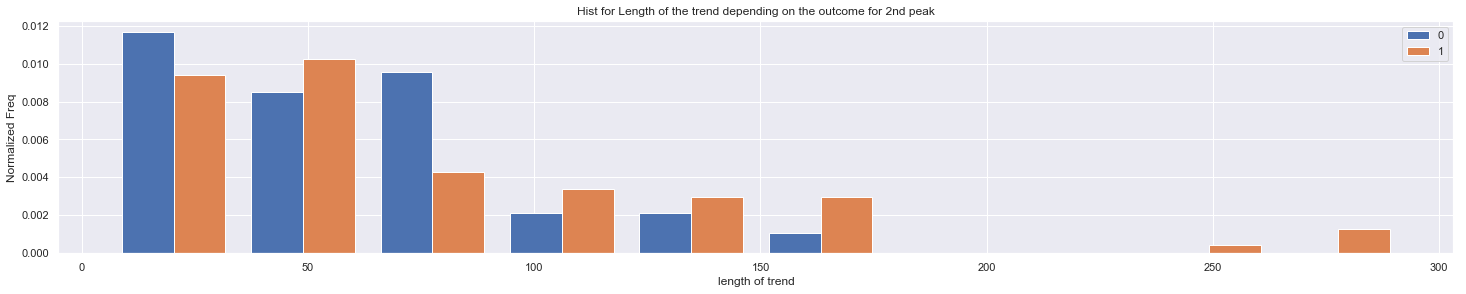

In [461]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of trend')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome for 2nd peak')

* Mean for each category

In [462]:
DF.groupby("outcome 2nd peak").agg({'length of trend 1st peak': 'mean'})

,length of trend 1st peak
outcome 2nd peak,
0,59.636364
1,78.353659


* Median for each category

In [463]:
DF.groupby("outcome 2nd peak").agg({'length of trend 1st peak': 'median'})

,length of trend 1st peak
outcome 2nd peak,
0,52
1,55


#### Binning data
Let's bin the data into a certain number of categories

In [464]:
max_v=max(DF['length of trend 1st peak'])

custom_bins_array = np.arange(0, max_v, 40)

DF['length of trend 1st peak_cat']=pd.cut(DF['length of trend 1st peak'], np.around(custom_bins_array))

##### outcome 1st peak

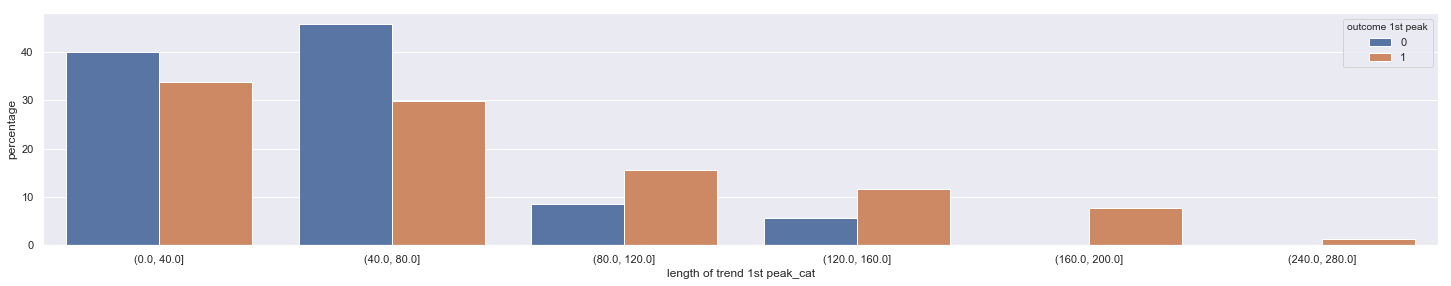

In [465]:
DF_counts = (DF.groupby(['outcome 1st peak'])['length of trend 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('length of trend 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="length of trend 1st peak_cat", y="percentage", hue='outcome 1st peak', data=DF_counts)

##### outcome 2nd peak

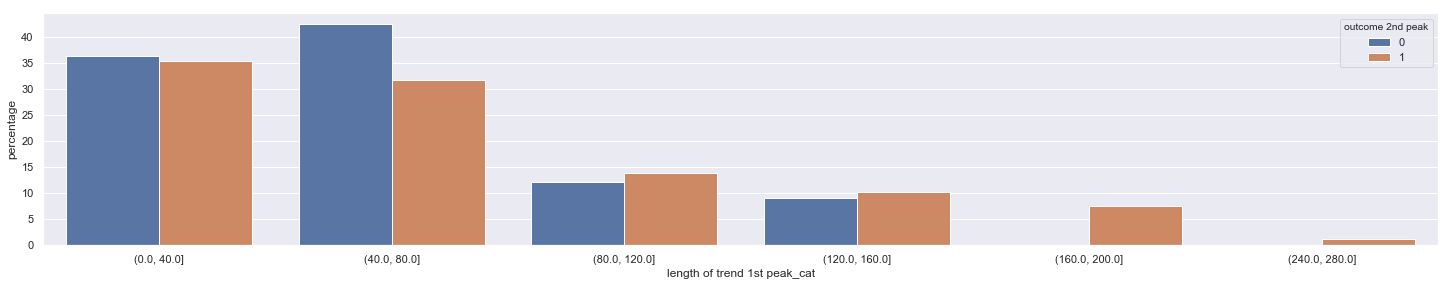

In [466]:
DF_counts = (DF.groupby(['outcome 2nd peak'])['length of trend 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('length of trend 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="length of trend 1st peak_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

### Pips_ratio
This variable contains the ratio between 'length of trend 1st peak'/'length in pips'

In [467]:
DF['pips_ratio']=DF['length in pips'].astype(int)/DF['length of trend 1st peak'].astype(int)

And the relationship between the `pips_ratio` and the outcome for the 1st and the 2nd peak is:
#### outcome 1st peak

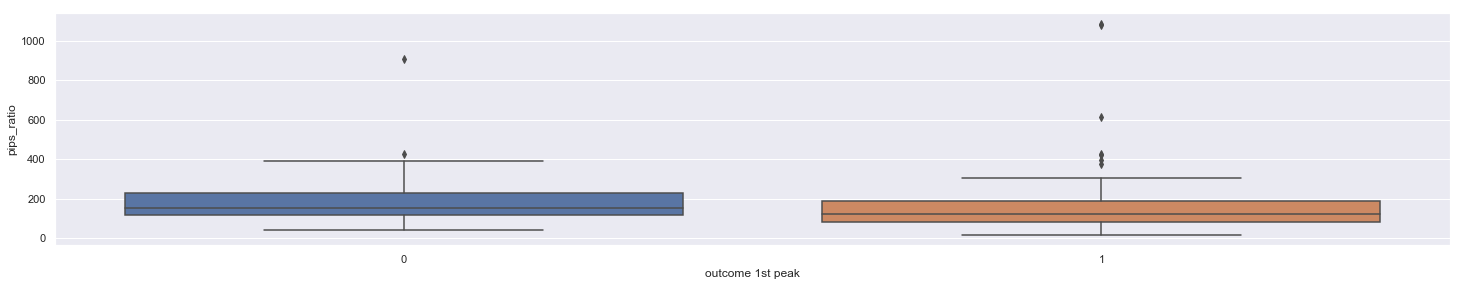

In [468]:
ax = sns.boxplot(x="outcome 1st peak", y="pips_ratio", data=DF)

* Mean for each category

In [469]:
DF.groupby("outcome 1st peak").agg({'pips_ratio': 'mean'})

,pips_ratio
outcome 1st peak,
0,194.898909
1,175.585344


* Median for each category

In [470]:
DF.groupby("outcome 1st peak").agg({'pips_ratio': 'median'})

,pips_ratio
outcome 1st peak,
0,154.076923
1,122.776221


Let's analyze the distribution with a histogram

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for Pips ratio on the outcome for the 1st peak')

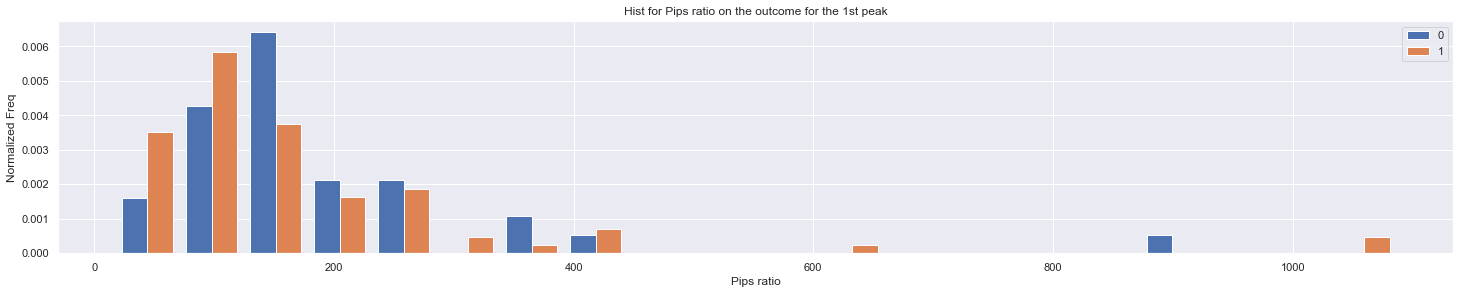

In [471]:
succ=DF.loc[DF["outcome 1st peak"]==1]['pips_ratio']
fail=DF.loc[DF["outcome 1st peak"]==0]['pips_ratio']

plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome for the 1st peak')

#### outcome 2nd peak

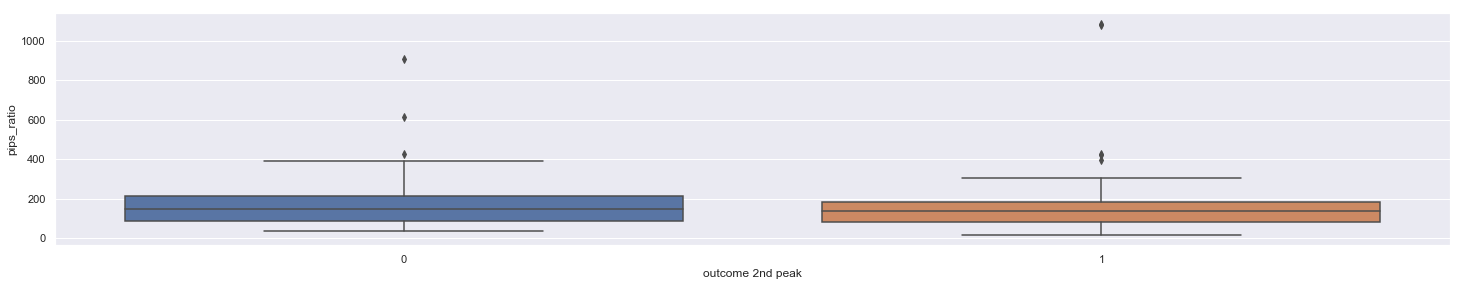

In [472]:
ax = sns.boxplot(x="outcome 2nd peak", y="pips_ratio", data=DF)

* Mean for each category

In [473]:
DF.groupby("outcome 2nd peak").agg({'pips_ratio': 'mean'})

,pips_ratio
outcome 2nd peak,
0,203.248105
1,172.696365


* Median for each category

In [474]:
DF.groupby("outcome 2nd peak").agg({'pips_ratio': 'median'})

,pips_ratio
outcome 2nd peak,
0,149.096154
1,138.453947


Let's analyze the distribution with a histogram

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for Pips ratio on the outcome for the 2nd peak')

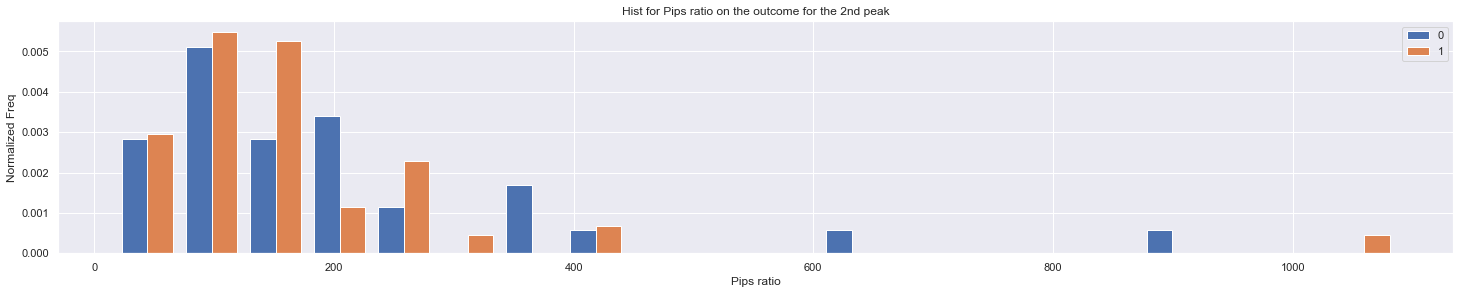

In [475]:
succ=DF.loc[DF["outcome 2nd peak"]==1]['pips_ratio']
fail=DF.loc[DF["outcome 2nd peak"]==0]['pips_ratio']

plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome for the 2nd peak')

#### Binning data
Let's bin the data into a certain number of categories

In [476]:
max_v=max(DF['pips_ratio'])

custom_bins_array = np.arange(0, max_v, 50)

DF['pips_ratio_cat']=pd.cut(DF['pips_ratio'], np.around(custom_bins_array))

##### outcome 1st peak

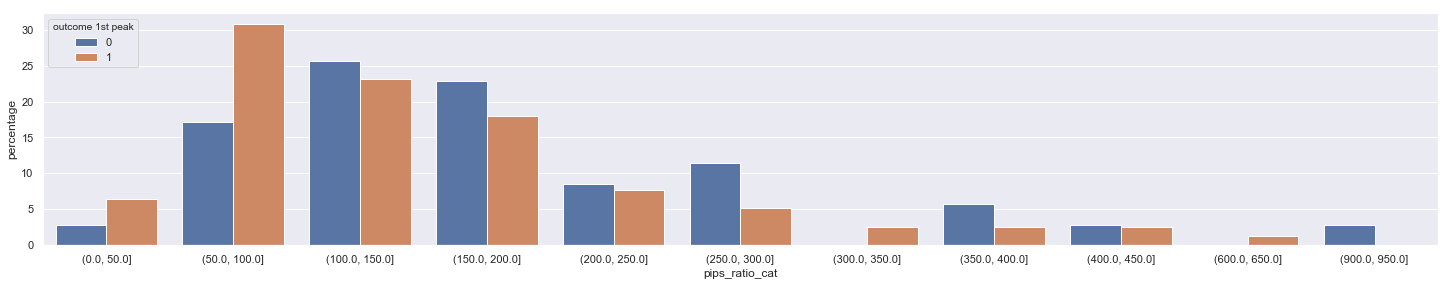

In [477]:
DF_counts = (DF.groupby(['outcome 1st peak'])['pips_ratio_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('pips_ratio_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="pips_ratio_cat", y="percentage", hue='outcome 1st peak', data=DF_counts)

##### outcome 2nd peak

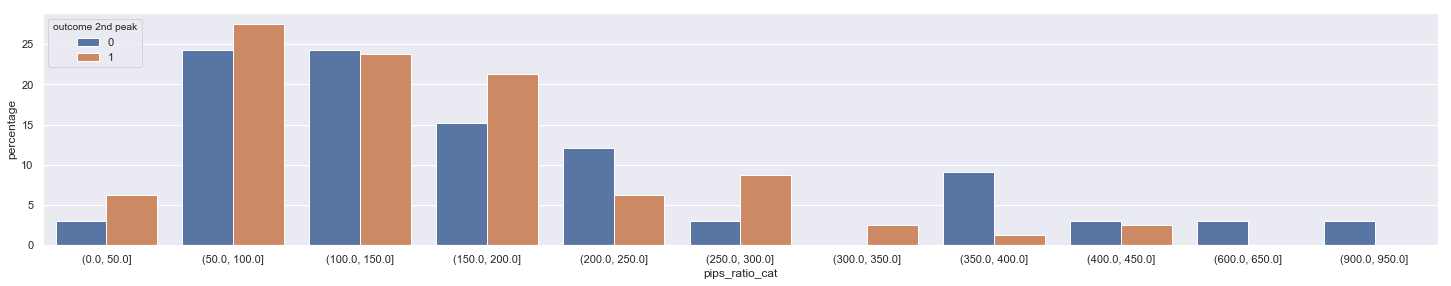

In [478]:
DF_counts = (DF.groupby(['outcome 2nd peak'])['pips_ratio_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('pips_ratio_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="pips_ratio_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

### bounces 1st peak
This quantitative discrete variable is used for representing the number of times the price has tested this level. Let's start comparing the distribution of this variable for the different categories of the outcome variable.

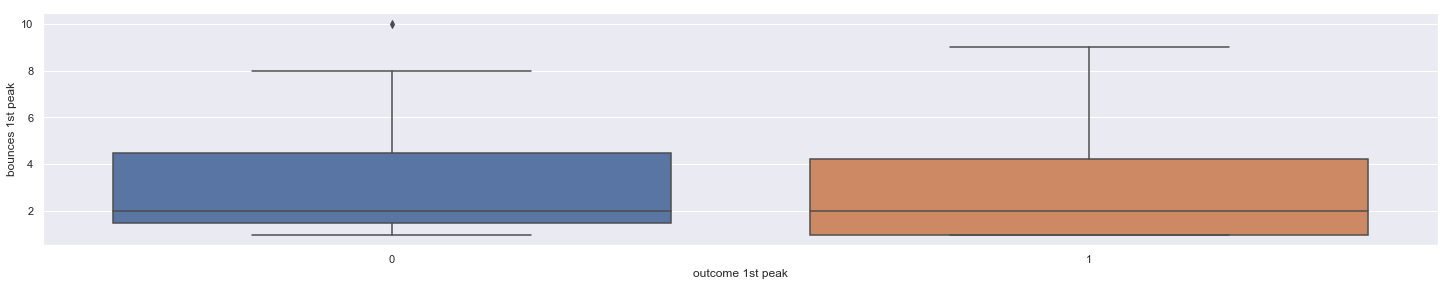

In [479]:
ax = sns.boxplot(x="outcome 1st peak", y="bounces 1st peak", data=DF)

* Mean for each category

In [480]:
DF.groupby("outcome 1st peak").agg({'bounces 1st peak': 'mean'})

,bounces 1st peak
outcome 1st peak,
0,3.114286
1,3.112500


In [481]:
DF.groupby("outcome 2nd peak").agg({'bounces 1st peak': 'mean'})

,bounces 1st peak
outcome 2nd peak,
0,2.696970
1,3.280488


* Median for each category

In [482]:
DF.groupby("outcome 1st peak").agg({'bounces 1st peak': 'median'})

,bounces 1st peak
outcome 1st peak,
0,2
1,2


In [483]:
DF.groupby("outcome 2nd peak").agg({'bounces 1st peak': 'median'})

,bounces 1st peak
outcome 2nd peak,
0,2
1,3


#### Binning data
Let's bin the data into a certain number of categories

In [484]:
max_v=max(DF['bounces 1st peak'])

custom_bins_array = np.arange(0, max_v, 1)

DF['bounces 1st peak_cat']=pd.cut(DF['bounces 1st peak'], np.around(custom_bins_array))

##### outcome 1st peak

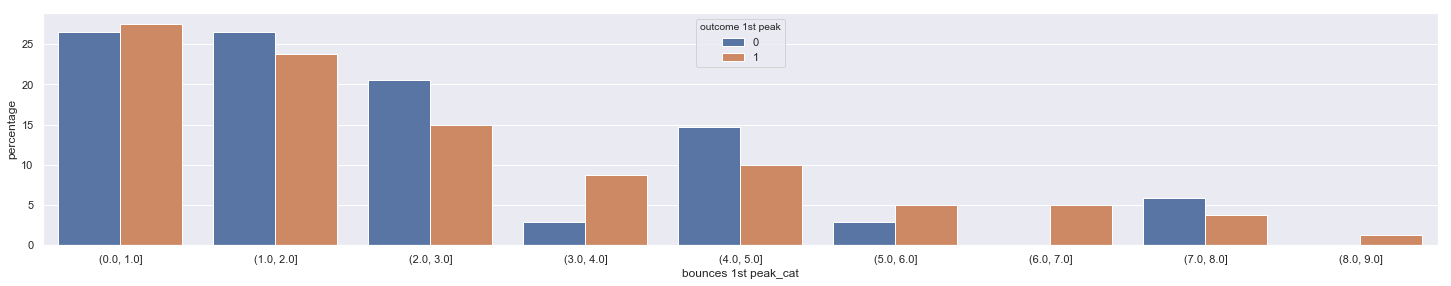

In [485]:
DF_counts = (DF.groupby(['outcome 1st peak'])['bounces 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('bounces 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="bounces 1st peak_cat", y="percentage", hue='outcome 1st peak', data=DF_counts)

##### outcome 2nd peak

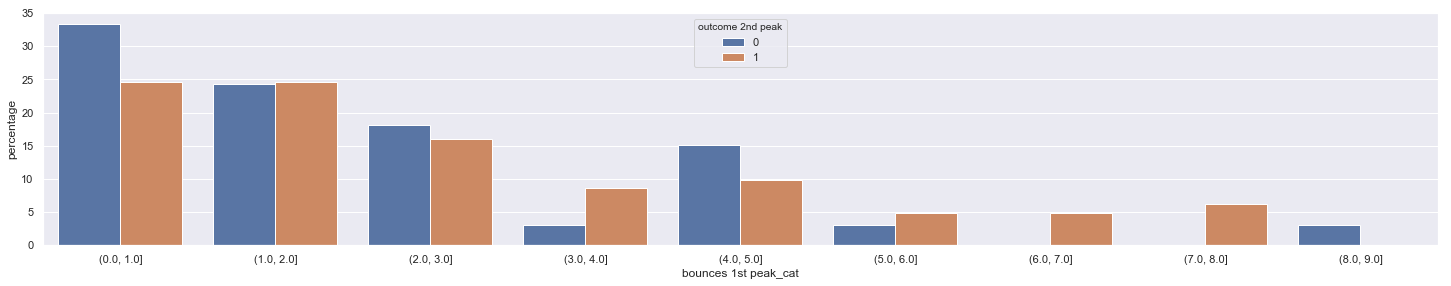

In [486]:
DF_counts = (DF.groupby(['outcome 2nd peak'])['bounces 1st peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('bounces 1st peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="bounces 1st peak_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

###  RSI 2nd peak
This numerical variable represents the value of the RSI indicator for the 2nd peak. We will create a categorical variable that will be 1 if the value is in overbought/oversold region (>70 or <30 respectively) and 0 otherwise. For that calculation we use the function defined before

In [487]:
DF['rsi_inarea_2nd']=DF['RSI 2nd peak'].apply(in_RSIarea)

Now, let's calculate the percentages of trades in oversold/overbought depending on the `outcome 2nd peak` variable:

In [488]:
div_class=pd.crosstab(DF.loc[:,"outcome 2nd peak"], DF['rsi_inarea_2nd'],margins=True)
print(div_class)

rsi_inarea_2nd     0   1  All
outcome 2nd peak             
0                 27   6   33
1                 70  12   82
All               97  18  115


In [489]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

rsi_inarea_2nd             0           1         All
outcome 2nd peak                                    
0                  27.835052   33.333333   28.695652
1                  72.164948   66.666667   71.304348
All               100.000000  100.000000  100.000000


*Conclusion:* The RSI value of the 2nd peak being in overbought/oversold is irrelevent for predicting the `outcome 2nd peak`

### divergence 2nd peak

Let's compare the proportions for this variable between the 2 categories of the `outcome 2nd peak` variable

In [490]:
div_class=pd.crosstab(DF.loc[:,"outcome 2nd peak"], DF['divergence 2nd peak'],margins=True)
print(div_class)

divergence 2nd peak   0   1  All
outcome 2nd peak                
0                    26   7   33
1                    65  17   82
All                  91  24  115


It's is easier to visualize the relationship if we calculate the percentages:

In [491]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

divergence 2nd peak           0           1         All
outcome 2nd peak                                       
0                     28.571429   29.166667   28.695652
1                     71.428571   70.833333   71.304348
All                  100.000000  100.000000  100.000000


###  valley
Is a quantitative numerical variable representing the number of candles between the first and the second peak.
Let's examine the distribution of `valley` depending on `outcome 2nd peak`

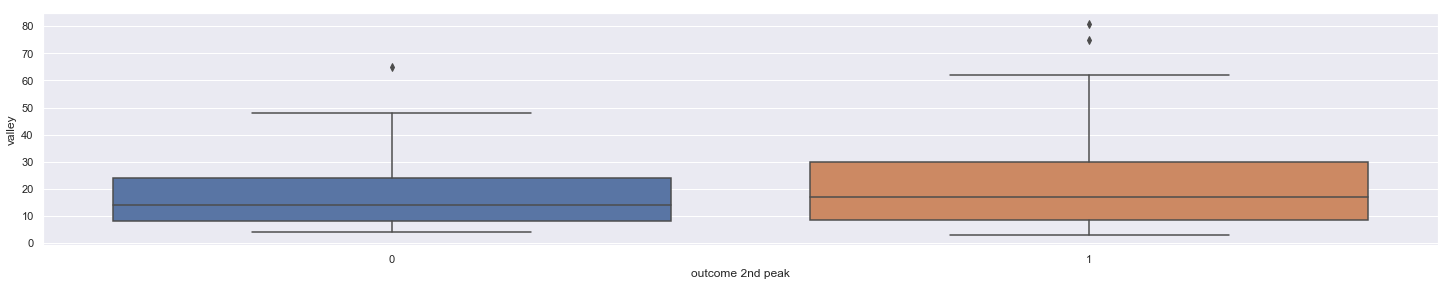

In [492]:
ax = sns.boxplot(x="outcome 2nd peak", y="valley", data=DF)

* Mean for each category

In [493]:
DF.groupby("outcome 2nd peak").agg({'valley': 'mean'})

,valley
outcome 2nd peak,
0,18.606061
1,21.195122


* Median for each category

In [494]:
DF.groupby("outcome 2nd peak").agg({'valley': 'median'})

,valley
outcome 2nd peak,
0,14
1,17


* Histogram

In [495]:
succ=DF.loc[DF["outcome 2nd peak"]==1]['valley']
fail=DF.loc[DF["outcome 2nd peak"]==0]['valley']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for valley depending on the outcome of the 2nd peak')

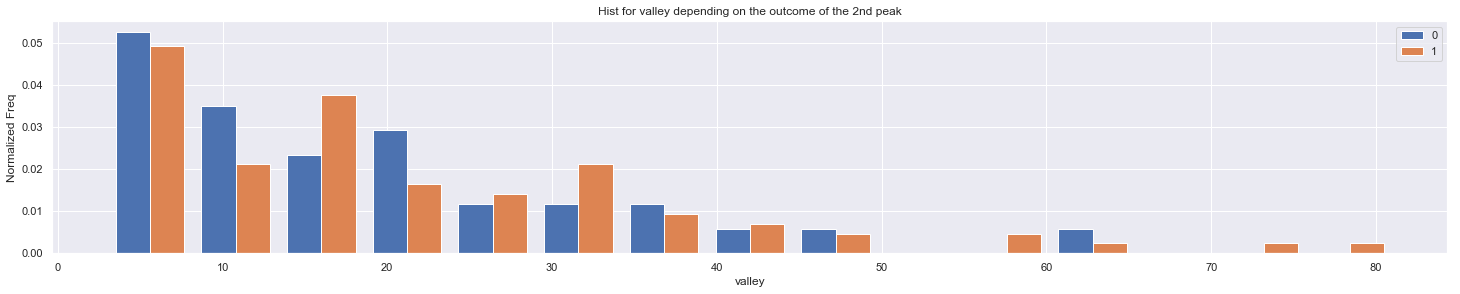

In [496]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('valley')
plt.ylabel('Normalized Freq')
plt.title('Hist for valley depending on the outcome of the 2nd peak')

#### Binning data
Let's bin the data into a certain number of categories

In [497]:
max_v=max(DF['valley'])

custom_bins_array = np.arange(0, max_v, 10)

DF['valley_cat']=pd.cut(DF['valley'], np.around(custom_bins_array))

##### outcome 2nd peak

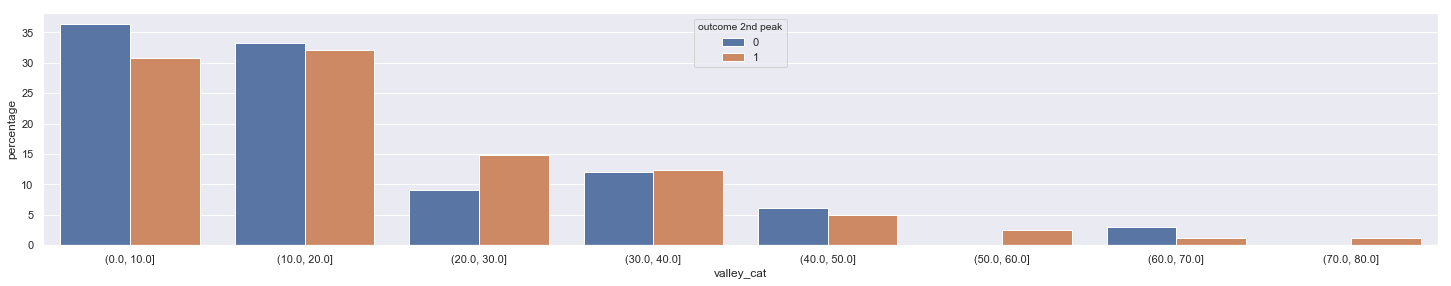

In [498]:
DF_counts = (DF.groupby(['outcome 2nd peak'])['valley_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('valley_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="valley_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

### differential
Firstly, we are going to create a categorical variable that will be 1 if `differential` is <0 and 0 if `differential` is >0

In [499]:
def diff_cat(x):
    '''
    Function to check if differential is <0 or >0
    
    Parameters
    ----------
    x = differential value
        
    Returns
    -------
    1 if differential is <0
    0 if differential is >0
    '''
   
    if x<0: 
        return 1
    else:
        return 0

Now, let's create the new variable named `diff_cat`:

Let's compare the proportions for this new variable between the 2 categories of the `outcome 2nd peak` variable

In [501]:
div_class=pd.crosstab(DF.loc[:,"outcome 2nd peak"], DF['diff_cat'],margins=True)
print(div_class)

diff_cat           0   1  All
outcome 2nd peak             
0                 16  17   33
1                 47  35   82
All               63  52  115


It's is easier to visualize the relationship if we calculate the percentages:

In [502]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

diff_cat                   0           1         All
outcome 2nd peak                                    
0                  25.396825   32.692308   28.695652
1                  74.603175   67.307692   71.304348
All               100.000000  100.000000  100.000000


Now, let's see the distribution of the `differential` variable depending on the value of `diff cat`:

#### diff_cat=0
When the differential is positive we have the following distribution of the differential values depending on the `outcome of the 2nd peak`:

In [503]:
diff_cat0_DF=DF[DF.loc[:,"diff_cat"]==0]

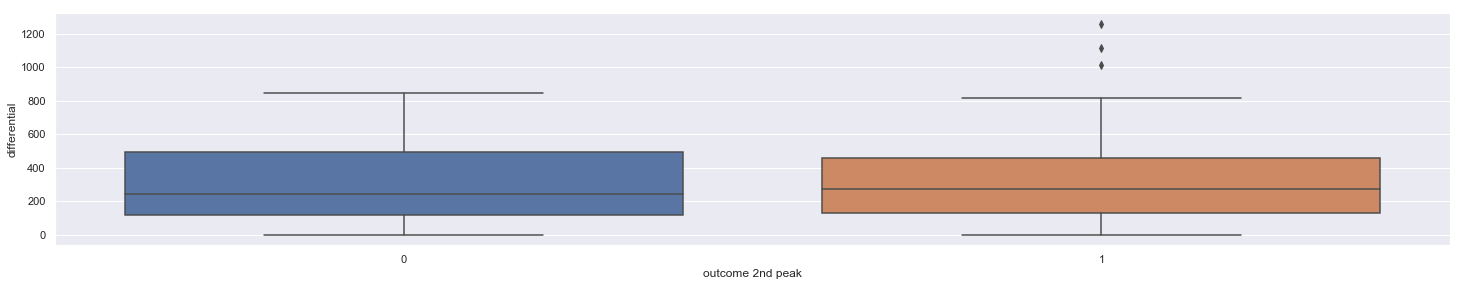

In [504]:
ax = sns.boxplot(x="outcome 2nd peak", y="differential", data=diff_cat0_DF)

* Mean for each category

In [505]:
diff_cat0_DF.groupby("outcome 2nd peak").agg({'differential': 'mean'})

,differential
outcome 2nd peak,
0,320.187500
1,356.297872


* Median for each category

In [506]:
diff_cat0_DF.groupby("outcome 2nd peak").agg({'differential': 'median'})

,differential
outcome 2nd peak,
0,241
1,273


* Histogram

In [507]:
succ=diff_cat0_DF.loc[DF["outcome 2nd peak"]==1]['differential']
fail=diff_cat0_DF.loc[DF["outcome 2nd peak"]==0]['differential']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for differential depending on the outcome of the 2nd peak')

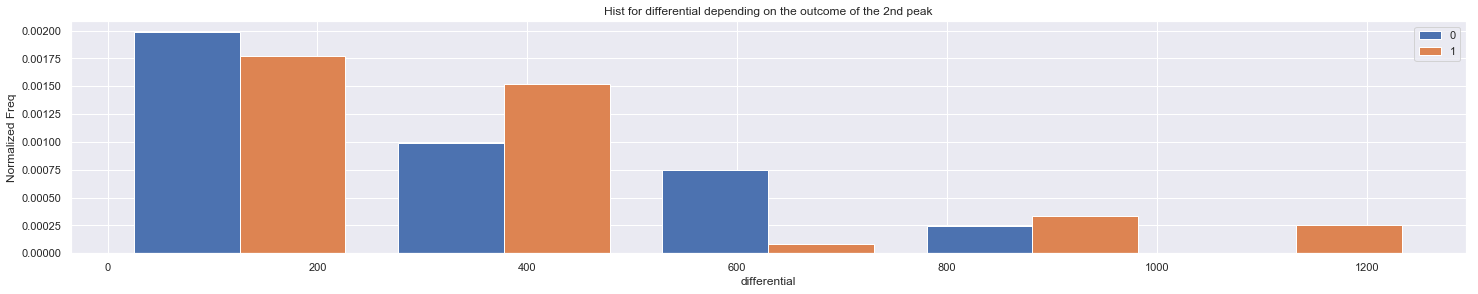

In [508]:
plt.hist([fail,succ], bins = 5, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('differential')
plt.ylabel('Normalized Freq')
plt.title('Hist for differential depending on the outcome of the 2nd peak')

#### Binning data
Let's bin the data into a certain number of categories

In [509]:
max_v=max(diff_cat0_DF['differential'])

custom_bins_array = np.arange(0, max_v, 100)

diff_cat0_DF['differential_cat']=pd.cut(diff_cat0_DF['differential'], np.around(custom_bins_array))

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


##### outcome 2nd peak

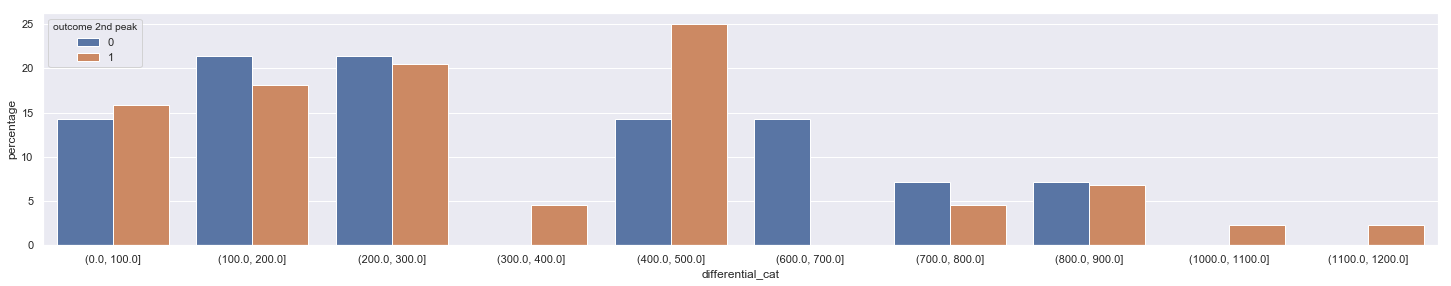

In [511]:
DF_counts = (diff_cat0_DF.groupby(['outcome 2nd peak'])['differential_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('differential_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="differential_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

#### diff_cat=1
When the differential is negative we have the following distribution of the differential values depending on the `outcome of the 2nd peak`:

In [520]:
diff_cat1_DF=DF[DF.loc[:,"diff_cat"]==1]

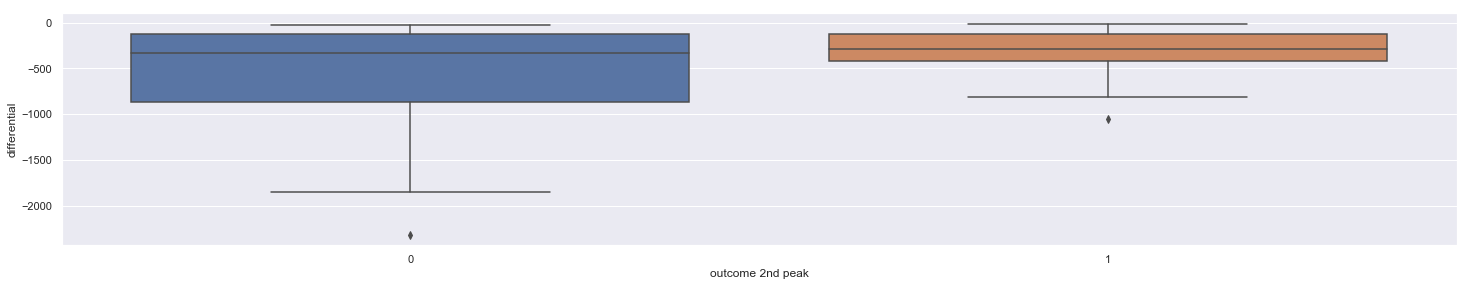

In [521]:
ax = sns.boxplot(x="outcome 2nd peak", y="differential", data=diff_cat1_DF)

* Mean for each category

In [522]:
diff_cat1_DF.groupby("outcome 2nd peak").agg({'differential': 'mean'})

,differential
outcome 2nd peak,
0,-593.764706
1,-311.371429


* Median for each category

In [529]:
diff_cat1_DF.groupby("outcome 2nd peak").agg({'differential': 'median'})

,differential
outcome 2nd peak,
0,-330
1,-283


* Histogram

In [530]:
succ=diff_cat1_DF.loc[DF["outcome 2nd peak"]==1]['differential']
fail=diff_cat1_DF.loc[DF["outcome 2nd peak"]==0]['differential']

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Hist for differential depending on the outcome of the 2nd peak')

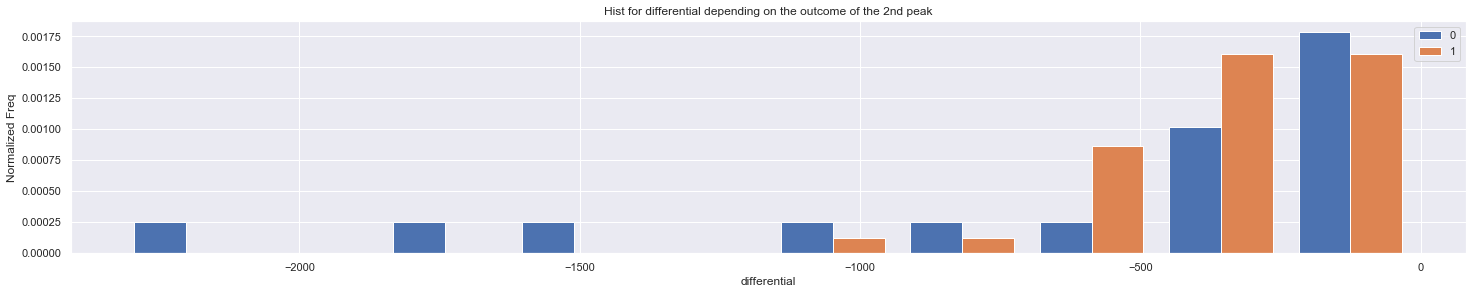

In [544]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('differential')
plt.ylabel('Normalized Freq')
plt.title('Hist for differential depending on the outcome of the 2nd peak')

#### Binning data
Let's bin the data into a certain number of categories

In [542]:
min_v=min(diff_cat1_DF['differential'])

custom_bins_array = np.arange(0, min_v, -50)
print(custom_bins_array)

diff_cat1_DF['differential_cat']=pd.cut(diff_cat1_DF['differential'], np.around(custom_bins_array))

[    0   -50  -100  -150  -200  -250  -300  -350  -400  -450  -500  -550
  -600  -650  -700  -750  -800  -850  -900  -950 -1000 -1050 -1100 -1150
 -1200 -1250 -1300 -1350 -1400 -1450 -1500 -1550 -1600 -1650 -1700 -1750
 -1800 -1850 -1900 -1950 -2000 -2050 -2100 -2150 -2200 -2250 -2300]


ValueError: bins must increase monotonically.

##### outcome 2nd peak

In [543]:
DF_counts = (diff_cat1_DF.groupby(['outcome 2nd peak'])['differential_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('differential_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="differential_cat", y="percentage", hue='outcome 2nd peak', data=DF_counts)

ValueError: min() arg is an empty sequence